In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Pesquisas/IC/spyder

!git clone https://github.com/alsombra/Mask_RCNN-TF2

/content/drive/MyDrive/Pesquisas/IC/spyder
fatal: destination path 'Mask_RCNN-TF2' already exists and is not an empty directory.


In [3]:
!pip install -r /path/Mask_RCNN-TF2/requirements.txt

In [4]:
!python /path/Mask_RCNN-TF2/setup.py install

INFO:root:running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standar

In [5]:
!pip install tensorflow==2.9.2
!pip install tensorflow-gpu==2.9.2

In [6]:
import sys
sys.path.append('/path/Mask_RCNN-TF2')

import os
import re
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pandas as pd
import skimage.draw
from skimage.io import imread
import skimage
import tensorflow
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log
import matplotlib.patches as patches
import skimage.io
from skimage.transform import resize
from skimage.morphology import erosion, dilation, disk, label
import numpy as np
import numpy as np
import skimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
# Print library versions
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("JSON version:", json.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tensorflow.__version__)

NumPy version: 1.23.5
OpenCV version: 4.8.0
Matplotlib version: 3.7.1
JSON version: 2.0.9
Pandas version: 1.5.3
TensorFlow version: 2.9.2


In [8]:
import tensorflow
tensorflow.__version__

'2.9.2'

In [9]:
class DatasetPersonalizado(utils.Dataset):

    def load_object(self, dataset_dir, subset, nome_annotation="via_region_data.json"):
        """Carrega um subconjunto do dataset vertebras.
        dataset_dir: Diretorio raíz do dataset.
        subset: Subconjunto a ser carregado: train (treinamento) ou val (validação)
        """
        # Adiciona as classes. Nesse exemplo, temos apenas uma classe para adicionar.
        self.add_class("vertebras", 1, "lombar")

        # Escolhe se é o dataset de Treinamento ou Validação
        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # O que mais interessa para nós são as coordenadas x e y de cada região
        # Obs: No VIA 2.0, as regiões são salvas em forma de lista ao invés de dicionario.
        annotations = json.load(open(os.path.join(dataset_dir, nome_annotation)))
        annotations = list(annotations.values())  # não precisa das dict keys

        # A ferramenta VIA salva as imagens em JSON mesmo que elas não contenham nenhuma anotação. Então, pulamos as imagens não anotadas.
        annotations = [a for a in annotations if a['regions']]

        contagem = 0
        # Adiciona as imagens
        for a in annotations:
            if len(a['regions']) < 5:
                continue


            # Extract slice number from the filename using regular expression
            filename = os.path.basename(a['filename'])
            slice_match = re.search(r'(\d+)\.jpg', filename)
            if slice_match:
                slice_number = int(slice_match.group(1))
            else:
                continue

            # Filter images based on slice number
            if slice_number < 4 or slice_number > 10:
               continue

            # Pega as coordenadas x e y dos pontos dos poligonos que formam o contorno de cada instância do objeto.
            # Eles são armazenadas em shape_attributes (para visualizar, abra o arquivo json)
            # A condição if é necessária para que o código suporte anotações geradas pelas versões 1.x e 2.x da VIA.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]



            # A função load_mask() vai precisar do tamanho da imagem para que possa converter os polígonos em mascaras.
            # Infelizmente, o VIA não inclui isso no JSON, então devemos ler a imagem manualmente e gerar essas máscaras.
            image_path = os.path.join(dataset_dir,"img", a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            contagem = contagem+1

            self.add_image("vertebras",
                image_id=a['filename'],  # usa o nome do arquivo como id unico da imagem
                path=image_path,
                width=width, height=height,
                polygons=polygons)

        print("Imagens "+subset+": " + str(contagem))

    def load_mask(self, image_id):
        """Gera as mascaras das instâncias para a imagem.
       Returna:
        masks: Uma array booleana de formato/shape [height, width, instance count] com 1 mascara por instancia.
        class_ids: uma array de 1D contendo os IDs das mascaras das instancias.
        """
        # Se não for uma imagem de conjunto de dados do balão (balloon dataset), delegue à classe ascendente.
        image_info = self.image_info[image_id]
        #print(image_info)
        if image_info["source"] != "vertebras":
            return super(self.__class__, self).load_mask(image_id)

        # Converte os poligonos em uma mascara bitmap com shape  [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        # Agora será calculado a máscara da instância. para cada pixel da imagem, classificará como pertencente à classe ou não
        for i, p in enumerate(info["polygons"]):
            # Pega os indices dos pixels dentro dos poligonos e define eles como = 1 (cor branca), caso contrário continuará valor 0 (cor preta)
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'], mask.shape) # passamos o .shape também como 3ª parâmetro para evitar possíveis erros

            mask[rr, cc, i] = 1

        # Retorna a mascara e a array dos IDs das classes de cada instancia.
        # Como nesse exemplo temos uma classe apenas, retornamos uma array composta de 1s
        return mask.astype(bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Retorna o caminho da imagem."""
        info = self.image_info[image_id]
        if info["source"] == "vertebras":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
nome_annotation = 'via_region_data.json'
path_dataset = "/path/patients"

# Conjunto de treinamento
dataset_train = DatasetPersonalizado()
dataset_train.load_object(path_dataset, 'train', nome_annotation)
dataset_train.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

Imagens train: 574
Images: 574
Classes: ['BG', 'lombar']


In [11]:
# Conjunto de validação
dataset_val = DatasetPersonalizado()
dataset_val.load_object(path_dataset, 'val', nome_annotation)
dataset_val.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

Imagens val: 117
Images: 117
Classes: ['BG', 'lombar']


In [12]:
# Conjunto de teste
dataset_test = DatasetPersonalizado()
dataset_test.load_object(path_dataset, 'test', nome_annotation)
dataset_test.prepare()
print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

Imagens test: 136
Images: 136
Classes: ['BG', 'lombar']


In [13]:
dataset_train.class_ids

array([0, 1])

In [14]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 10)
  plt.axis("off")
  plt.imshow(img)
  plt.show()

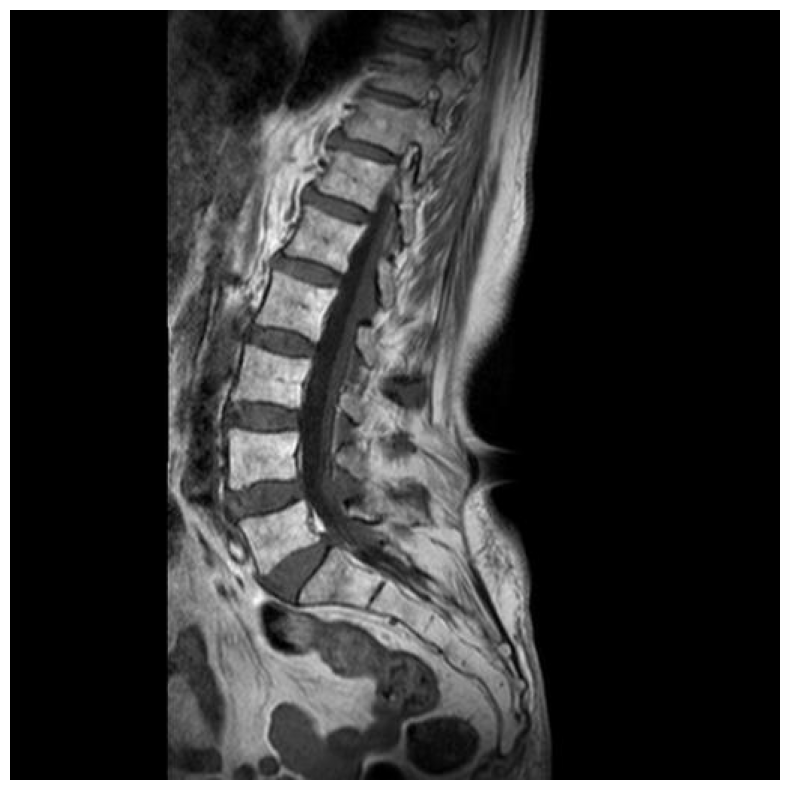

(array([[[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        [[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        [[False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False],
         ...,
         [False, False, False, False, False],
         [False, False, False, False, False],
         [False, False, False, False, False]],
 
        ...,
 
        [[False, False, False, False, False],
         [False, False, False, False, False],
         [Fals

In [15]:
img_id = 4
img = dataset_train.load_image(img_id)
mostrar(img)
dataset_train.image_reference(img_id)
mask, class_ids = dataset_train.load_mask(img_id)
mask
bbox = utils.extract_bboxes(mask)
mask.shape
bbox
mask, np.unique(mask, return_counts=True)

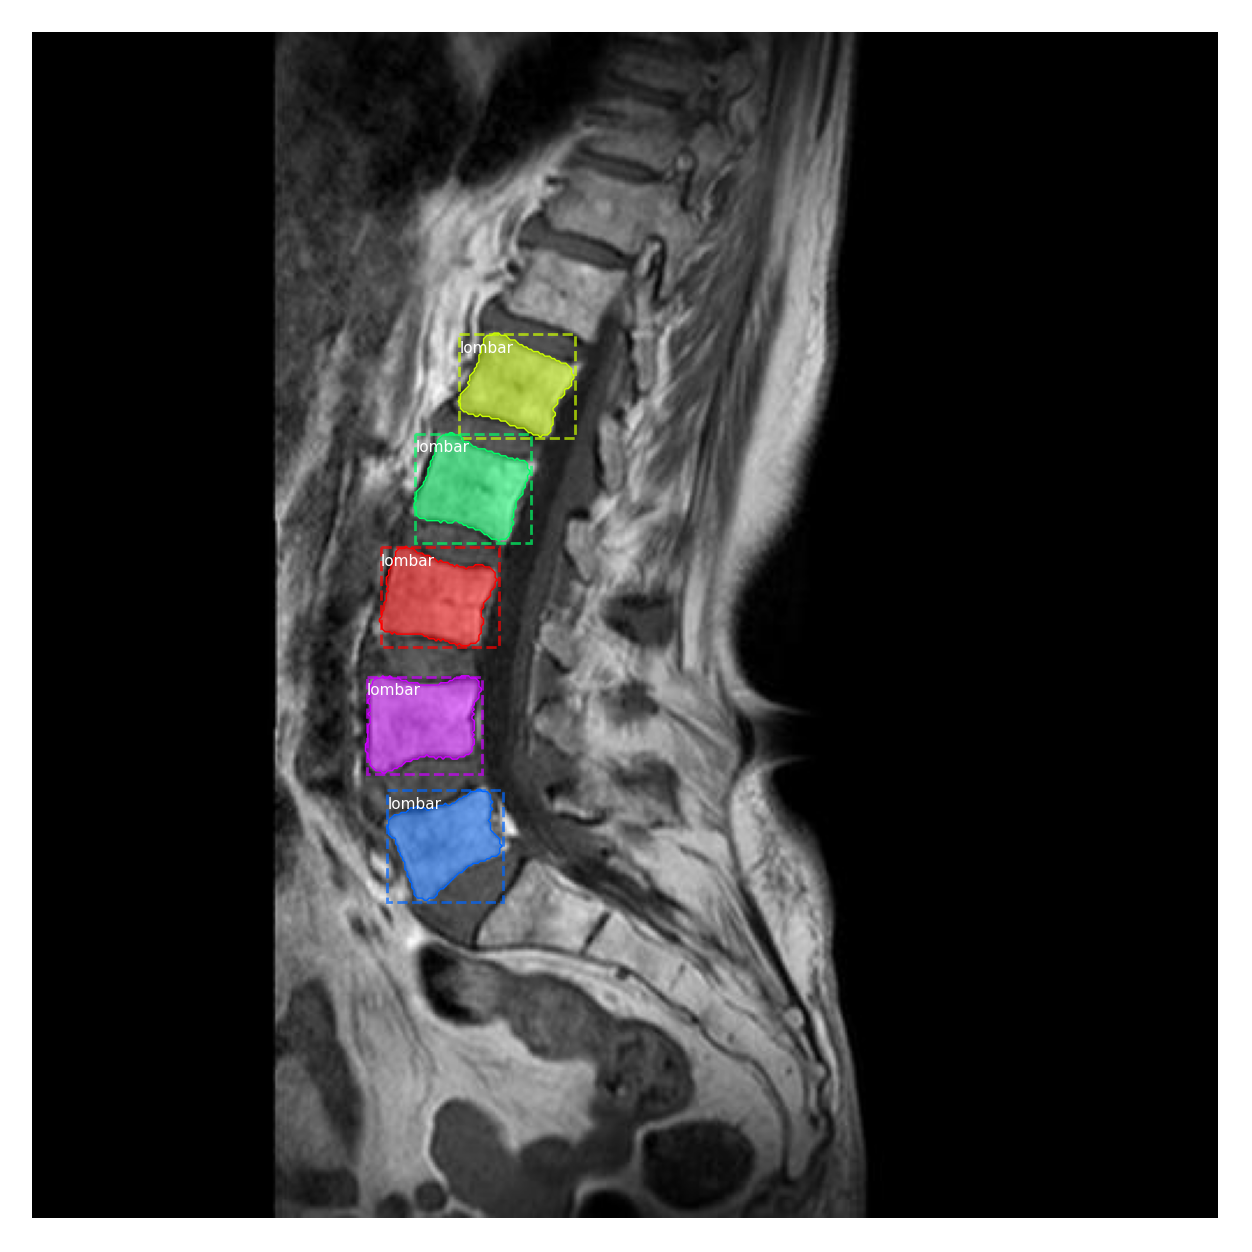

In [16]:
visualize.display_instances(img, bbox, mask, class_ids, dataset_val.class_names, show_bbox=True)

In [17]:
print('Imagem', img_id, dataset_train.image_reference(img_id))
log('image', img)
log('mask', mask)
log('class_ids', class_ids)
log('bbox', bbox)

Imagem 4 /content/drive/MyDrive/Pesquisas/IC/spyder/patients_balanced_70/train/img/01-SAG-T1-8Bits_7.jpg
image                    shape: (512, 512, 3)         min:    0.00000  max:  252.00000  uint8
mask                     shape: (512, 512, 5)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:  130.00000  max:  375.00000  int32


In [18]:
class ConfigRede(Config):
  NAME = 'vertebra'
  IMAGES_PER_GPU = 2
  NUM_CLASSES = 1 + 1
  STEPS_PER_EPOCH = 287 #574/2 -> n imagens / batch_size
  DETECTION_MIN_CONFIDENCE = 0.80
  USE_MINI_MASK = False
  TRAIN_ROIS_PER_IMAGE = 32 #tentar diminuir
  RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
  DETECTION_MAX_INSTANCES = 5
  ROI_POSITIVE_RATIO = 0.70
  MAX_GT_INSTANCES = 5
  LEARNING_RATE = 0.001
  WEIGHT_DECAY = 0.0001
  IMAGE_MIN_DIM = 512
  IMAGE_MAX_DIM = 512
  VALIDATION_STEPS = 59 #117/2 VAL
config = ConfigRede()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        5
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [ ]:
path_raiz = os.path.abspath('Mask_RCNN-TF2')

path_modelos = os.path.join(path_raiz, 'logs')
path_modelos

In [ ]:
# Transferência de aprendizagem
path_modelo_COCO = os.path.join(path_raiz, 'mask_rcnn_coco.h5')
path_modelo_COCO

In [21]:
if not os.path.exists(path_modelo_COCO):
  utils.download_trained_weights(path_modelo_COCO)

def carrega_modelo_treinamento(config, inicia_com = 'coco', model_path=''):
  model = modellib.MaskRCNN(mode = 'training', config = config, model_dir=model_path)
  if inicia_com == 'coco':
    model.load_weights(path_modelo_COCO, by_name = True, exclude = ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])
  elif inicia_com == 'imagenet':
    model.load_weights(model.get_imagenet_weights(), by_name=True)
  elif inicia_com == 'last':
    if model_path == "":
      model_path = model.find_last()
    model.load_weights(model_path, by_name=True)

  return model

In [22]:
model = carrega_modelo_treinamento(config, '/content/drive/MyDrive/Pesquisas/IC/spyder/Mask_RCNN-TF2/mask_rcnn_coco.h5')

In [ ]:
#LEARNING RATE PADRAO 0.001
inicio = time.time()
model.train(dataset_train, dataset_val, learning_rate = config.LEARNING_RATE, epochs = 100, layers='heads') # all
fim_treino = time.time()
minutos = round((fim_treino - inicio) / 60, 2)
print('Tempo de treinamento: ', minutos)


Starting at epoch 0. LR=0.001

Checkpoint Path: vertebra20231114T1144/mask_rcnn_vertebra_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrc

/usr/local/lib/python3.10/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(N

287/287 [==============================] - ETA: 0s - batch: 143.0000 - size: 2.0000 - loss: 7.2630 - rpn_class_loss: 0.3367 - rpn_bbox_loss: 4.4473 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 1.9975 - mrcnn_mask_loss: 0.3546

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


287/287 [==============================] - 123s 367ms/step - batch: 143.0000 - size: 2.0000 - loss: 7.2630 - rpn_class_loss: 0.3367 - rpn_bbox_loss: 4.4473 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 1.9975 - mrcnn_mask_loss: 0.3546 - val_loss: 1.6909 - val_rpn_class_loss: 0.1036 - val_rpn_bbox_loss: 0.3887 - val_mrcnn_class_loss: 0.3372 - val_mrcnn_bbox_loss: 0.5529 - val_mrcnn_mask_loss: 0.3084
Epoch 2/100
287/287 [==============================] - 76s 265ms/step - batch: 143.0000 - size: 2.0000 - loss: 1.0617 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.2721 - mrcnn_class_loss: 0.1552 - mrcnn_bbox_loss: 0.3062 - mrcnn_mask_loss: 0.2775 - val_loss: 0.7539 - val_rpn_class_loss: 0.0373 - val_rpn_bbox_loss: 0.2136 - val_mrcnn_class_loss: 0.0610 - val_mrcnn_bbox_loss: 0.2257 - val_mrcnn_mask_loss: 0.2162
Epoch 3/100
287/287 [==============================] - 76s 266ms/step - batch: 143.0000 - size: 2.0000 - loss: 0.7077 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.1731 - mrcnn_class_loss

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 14 13:53:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    34W /  70W |   5921MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



In [23]:
class InferenceConfig(ConfigRede):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
inference_config = InferenceConfig()

In [ ]:
def carrega_modelo_teste(model_path='ultimo'):
  inference_config = InferenceConfig()
  model = modellib.MaskRCNN(mode = 'inference', config=inference_config, model_dir=model_path)
  if model_path == 'ultimo':
    model_path = model.find_last()
  print('Carregando os pesos de', model_path)
  model.load_weights(model_path, by_name=True)
  return model, inference_config

model_teste, inference_config = carrega_modelo_teste('/path/vertebra20231114T1144/mask_rcnn_vertebra_0086.h5') # Melhor epoca foi inserida aqui posteriormente às mensurações

In [ ]:
best_mAP = 0  # Variável para rastrear o melhor mAP encontrado
best_model_path = None  # Variável para rastrear o caminho do modelo com o melhor mAP

for i in range(1, 101):
    model_path = f'/path/vertebra20231114T1144/mask_rcnn_vertebra_{i:04d}.h5'

    # Carregue o modelo com os pesos correspondentes
    model_teste, inference_config = carrega_modelo_teste(model_path)

    APs = []

    for img_id in dataset_val.image_ids:
        img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, img_id)

        resultados = model_teste.detect([img], verbose=0)
        r = resultados[0]

        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
        #print(f"mAP for {model_path} on image id {img_id}: {AP}")

    mean_mAP = np.mean(APs)
    print(f"Mean mAP for {model_path}: {mean_mAP}")

    # Verifique se este modelo tem o melhor mAP até agora
    #if mean_mAP > best_mAP:
    #    best_mAP = mean_mAP
    #    best_model_path = model_path

# Imprima o melhor mAP encontrado e o caminho do modelo correspondente
#print(f"Best mAP: {best_mAP} achieved with model: {best_model_path}")

Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0050.h5
Re-starting from epoch 50


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0050.h5: 0.9876923084259034
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0051.h5
Re-starting from epoch 51


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0051.h5: 0.9931623935699463
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0052.h5
Re-starting from epoch 52


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0052.h5: 0.9852991460734962
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0053.h5
Re-starting from epoch 53


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0053.h5: 0.9856410264459431
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0054.h5
Re-starting from epoch 54


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0054.h5: 0.9743589758872986
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0055.h5
Re-starting from epoch 55


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0055.h5: 0.9863247871398926
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0056.h5
Re-starting from epoch 56


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0056.h5: 0.9894017100334168
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0057.h5
Re-starting from epoch 57


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0057.h5: 0.9757264971733094
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0058.h5
Re-starting from epoch 58


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0058.h5: 0.9894017100334168
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0059.h5
Re-starting from epoch 59


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0059.h5: 0.9897435903549194
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0060.h5
Re-starting from epoch 60


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0060.h5: 0.9839316248384297
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0061.h5
Re-starting from epoch 61


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0061.h5: 0.974017095565796
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0062.h5
Re-starting from epoch 62


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0062.h5: 0.976068377494812
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0063.h5
Re-starting from epoch 63


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0063.h5: 0.9784615397453307
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0064.h5
Re-starting from epoch 64


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0064.h5: 0.9791453003883362
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0065.h5
Re-starting from epoch 65


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0065.h5: 0.9822222232818604
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0066.h5
Re-starting from epoch 66


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0066.h5: 0.9825641036033631
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0067.h5
Re-starting from epoch 67


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0067.h5: 0.9846153855323792
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0068.h5
Re-starting from epoch 68


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0068.h5: 0.988034188747406
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0069.h5
Re-starting from epoch 69


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0069.h5: 0.9726495742797852
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0070.h5
Re-starting from epoch 70


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0070.h5: 0.9863247871398926
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0071.h5
Re-starting from epoch 71


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0071.h5: 0.9876923084259034
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0072.h5
Re-starting from epoch 72


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0072.h5: 0.9757264971733094
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0073.h5
Re-starting from epoch 73


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0073.h5: 0.9846153855323792
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0074.h5
Re-starting from epoch 74


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0074.h5: 0.9829059839248657
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0075.h5
Re-starting from epoch 75


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0075.h5: 0.988034188747406
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0076.h5
Re-starting from epoch 76


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0076.h5: 0.983589744516927
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0077.h5
Re-starting from epoch 77


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0077.h5: 0.976068377494812
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0078.h5
Re-starting from epoch 78


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0078.h5: 0.974017095565796
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0079.h5
Re-starting from epoch 79


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0079.h5: 0.986410257092908
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0080.h5
Re-starting from epoch 80


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0080.h5: 0.9767521378576246
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0081.h5
Re-starting from epoch 81


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0081.h5: 0.980512821674347
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0082.h5
Re-starting from epoch 82


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0082.h5: 0.9777777791023254
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0083.h5
Re-starting from epoch 83


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0083.h5: 0.9846153855323792
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0084.h5
Re-starting from epoch 84


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0084.h5: 0.9733333348718464
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0085.h5
Re-starting from epoch 85


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0085.h5: 0.9856410264968872
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0086.h5
Re-starting from epoch 86


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0086.h5: 0.9839316248893739
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0087.h5
Re-starting from epoch 87


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0087.h5: 0.9811965823173523
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0088.h5
Re-starting from epoch 88


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0088.h5: 0.9791453003883362
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0089.h5
Re-starting from epoch 89


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0089.h5: 0.9808547019958497
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0090.h5
Re-starting from epoch 90


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0090.h5: 0.9709401726722717
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0091.h5
Re-starting from epoch 91


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0091.h5: 0.9897435903549194
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0092.h5
Re-starting from epoch 92


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0092.h5: 0.9856410263949988
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0093.h5
Re-starting from epoch 93


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0093.h5: 0.9777777791023254
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0094.h5
Re-starting from epoch 94


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0094.h5: 0.9811965823173523
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0095.h5
Re-starting from epoch 95


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0095.h5: 0.9846153855323792
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0096.h5
Re-starting from epoch 96


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0096.h5: 0.9911111116409302
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0097.h5
Re-starting from epoch 97


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0097.h5: 0.9897435903549194
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0098.h5
Re-starting from epoch 98


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0098.h5: 0.9778632490553408
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0099.h5
Re-starting from epoch 99


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0099.h5: 0.9914529919624329
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0100.h5
Re-starting from epoch 100


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0100.h5: 0.9897435903549194


In [25]:
best_mAP = 0  # Variável para rastrear o melhor mAP encontrado
best_model_path = None  # Variável para rastrear o caminho do modelo com o melhor mAP

for i in range(1, 101):
    model_path = f'/content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_{i:04d}.h5'

    # Carregue o modelo com os pesos correspondentes
    model_teste, inference_config = carrega_modelo_teste(model_path)

    APs = []

    for img_id in dataset_test.image_ids:
        img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, inference_config, img_id)

        resultados = model_teste.detect([img], verbose=0)
        r = resultados[0]

        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
        #print(f"mAP for {model_path} on image id {img_id}: {AP}")

    mean_mAP = np.mean(APs)
    print(f"Mean mAP for {model_path}: {mean_mAP}")

    # Verifique se este modelo tem o melhor mAP até agora
    #if mean_mAP > best_mAP:
    #    best_mAP = mean_mAP
    #    best_model_path = model_path

# Imprima o melhor mAP encontrado e o caminho do modelo correspondente
#print(f"Best mAP: {best_mAP} achieved with model: {best_model_path}")

Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0054.h5
Re-starting from epoch 54


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0054.h5: 0.8844117689658613
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0055.h5
Re-starting from epoch 55


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0055.h5: 0.9032352989977773
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0056.h5
Re-starting from epoch 56


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0056.h5: 0.8907107894181037
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0057.h5
Re-starting from epoch 57


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0057.h5: 0.914411769111586
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0058.h5
Re-starting from epoch 58


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0058.h5: 0.8833088284687085
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0059.h5
Re-starting from epoch 59


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0059.h5: 0.8951470640104484
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0060.h5
Re-starting from epoch 60


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0060.h5: 0.8810049070848847
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0061.h5
Re-starting from epoch 61


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0061.h5: 0.8877941221765736
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0062.h5
Re-starting from epoch 62


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0062.h5: 0.8585294168661624
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0063.h5
Re-starting from epoch 63


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0063.h5: 0.8874509849549072
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0064.h5
Re-starting from epoch 64


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0064.h5: 0.8652941222138264
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0065.h5
Re-starting from epoch 65


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0065.h5: 0.8920833382664213
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0066.h5
Re-starting from epoch 66


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0066.h5: 0.8930882402093095
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0067.h5
Re-starting from epoch 67


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0067.h5: 0.8940441230969394
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0068.h5
Re-starting from epoch 68


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0068.h5: 0.904558828588137
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0069.h5
Re-starting from epoch 69


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0069.h5: 0.8919607890532443
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0070.h5
Re-starting from epoch 70


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0070.h5: 0.8998529454967117
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0071.h5
Re-starting from epoch 71


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0071.h5: 0.8968382405664992
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0072.h5
Re-starting from epoch 72


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0072.h5: 0.8650000051102218
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0073.h5
Re-starting from epoch 73


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0073.h5: 0.9047058872659417
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0074.h5
Re-starting from epoch 74


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0074.h5: 0.900490200775219
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0075.h5
Re-starting from epoch 75


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0075.h5: 0.8808823576251812
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0076.h5
Re-starting from epoch 76


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0076.h5: 0.8735049072525227
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0077.h5
Re-starting from epoch 77


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0077.h5: 0.8959313773312698
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0078.h5
Re-starting from epoch 78


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0078.h5: 0.8957352996091633
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0079.h5
Re-starting from epoch 79


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0079.h5: 0.9027205930036657
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0080.h5
Re-starting from epoch 80


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0080.h5: 0.9009558872484109
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0081.h5
Re-starting from epoch 81


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0081.h5: 0.9038970636970857
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0082.h5
Re-starting from epoch 82


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0082.h5: 0.8998529462855966
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0083.h5
Re-starting from epoch 83


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0083.h5: 0.9007352988893057
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0084.h5
Re-starting from epoch 84


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0084.h5: 0.9039705931428164
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0085.h5
Re-starting from epoch 85


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0085.h5: 0.8973774559101929
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0086.h5
Re-starting from epoch 86


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0086.h5: 0.9205882395015044
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0087.h5
Re-starting from epoch 87


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0087.h5: 0.9070588286089547
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0088.h5
Re-starting from epoch 88


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0088.h5: 0.9026225535619056
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0089.h5
Re-starting from epoch 89


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0089.h5: 0.9040441223420204
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0090.h5
Re-starting from epoch 90


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0090.h5: 0.9025490240942614
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0091.h5
Re-starting from epoch 91


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0091.h5: 0.9083823575747803
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0092.h5
Re-starting from epoch 92


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0092.h5: 0.9041911812170464
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0093.h5
Re-starting from epoch 93


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0093.h5: 0.8933823573786546
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0094.h5
Re-starting from epoch 94


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0094.h5: 0.8948529468137113
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0095.h5
Re-starting from epoch 95


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0095.h5: 0.878848044219993
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0096.h5
Re-starting from epoch 96


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0096.h5: 0.8902941230574951
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0097.h5
Re-starting from epoch 97


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0097.h5: 0.9094117692726501
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0098.h5
Re-starting from epoch 98


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0098.h5: 0.9020588286001893
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0099.h5
Re-starting from epoch 99


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0099.h5: 0.9140441220363273
Carregando os pesos de /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0100.h5
Re-starting from epoch 100


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean mAP for /content/drive/MyDrive/Pesquisas/IC/spyder/vertebra20231114T1144/mask_rcnn_vertebra_0100.h5: 0.9030147108961555


In [34]:
# Métrica para validacao
APs = []
for img_id in dataset_val.image_ids:
  #print(img_id)
  img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, img_id)

  resultados = model_teste.detect([img], verbose=0)
  r = resultados[0]

  AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
  APs.append(AP)
  #print(AP)
print('mAP: ', np.mean(APs))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


mAP:  0.9839316248893739


In [35]:
#mAP para imagens de teste
APs = []
for img_id in dataset_test.image_ids:
  #print(img_id)
  img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, inference_config, img_id)

  resultados = model_teste.detect([img], verbose=0)
  r = resultados[0]
  img_path = dataset_test.image_reference(img_id)
  img_test = imread(img_path)
  #segmentar_imagem(model_teste, img_test)
  AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
  APs.append(AP)
  #print(AP, 'image id', img_id)
print('mAP: ', np.mean(APs))

mAP:  0.9205882395015044


{'rois': array([[181, 199, 224, 250],
       [235, 191, 266, 242],
       [136, 213, 175, 260],
       [273, 199, 317, 239],
       [ 93, 221, 132, 273]], dtype=int32), 'class_ids': array([1, 1, 1, 1, 1], dtype=int32), 'scores': array([0.9999964 , 0.9999957 , 0.999995  , 0.9999788 , 0.99920446],
      dtype=float32), 'masks': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [Fal

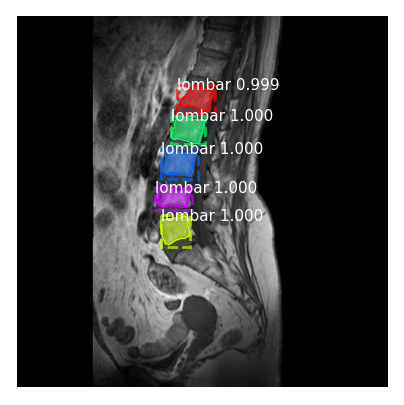

In [36]:
#img_teste = dataset_test.load_image(4)
img_teste = imread("/path/patients/val/img/63-SAG-T1-8Bits_7.jpg")

def segmentar_imagem(model_teste, img):
  resultados = model_teste.detect([img], verbose=0)
  r = resultados[0]
  print(r)
  visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(5,5))
  return r

from skimage.io import imread
#mostrar(img_teste)

r = segmentar_imagem(model_teste, img_teste)


In [38]:
def compara_validacao(model_teste, img_id, dataset_test, inference_config):

    img_original, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, inference_config,
                                                                                   img_id)

    print("Resultado do modelo treinado vs. Anotação da máscara original (ground-truth)")

    # Resultado do modelo treinado
    resultados = model_teste.detect([img_original], verbose=0)
    r = resultados[0]
    visualize.display_instances(img_original, r['rois'], r['masks'], r['class_ids'],
                                dataset_test.class_names, r['scores'], figsize = (4,4))

    # Anotação da máscara original (ground-truth)
    visualize.display_instances(img_original, gt_bbox, gt_mask, gt_class_id,
                                dataset_test.class_names, figsize=(4, 4))

/content/drive/MyDrive/Pesquisas/IC/spyder/patients_balanced_70/test/img/52-SAG-T1-8Bits_4.jpg
Resultado do modelo treinado vs. Anotação da máscara original (ground-truth)


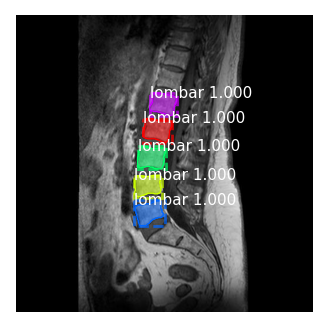

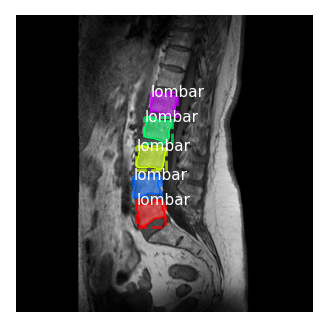

In [40]:
import random
img_id = random.choice(dataset_test.image_ids)
print(dataset_test.image_reference(img_id))
compara_validacao(model_teste, img_id, dataset_val, inference_config)

In [41]:
def apply_cutout_segmentation(image, mask):
    if mask.shape[-1] > 0:
        mask = np.sum(mask, -1, keepdims=True) >= 1
        background = np.ones_like(image) * 255  # Define o fundo branco
        segmented_image = np.where(mask, image, background).astype(np.uint8)
    else:
        segmented_image = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255

    return segmented_image

{'rois': array([[290, 191, 336, 232],
       [189, 198, 233, 251],
       [237, 189, 279, 240],
       [142, 215, 186, 270],
       [105, 235, 144, 285]], dtype=int32), 'class_ids': array([1, 1, 1, 1, 1], dtype=int32), 'scores': array([0.9999976 , 0.99999297, 0.99998474, 0.99995446, 0.99928856],
      dtype=float32), 'masks': array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        ...,
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [Fal

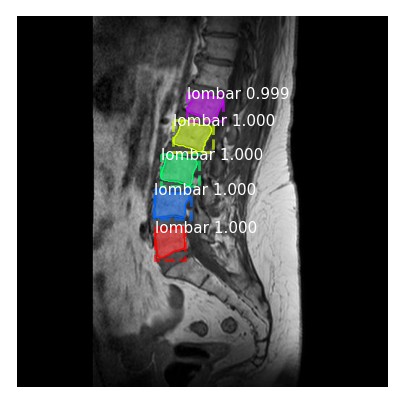

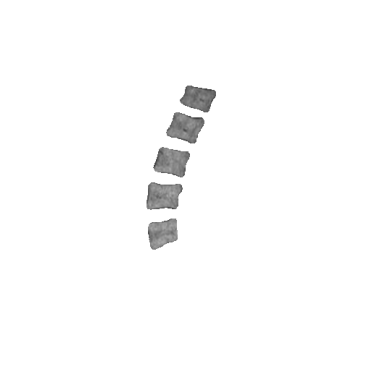

In [44]:
from skimage.io import imread

# Carrega a imagem de teste
img_original = imread('/path/patients/test/img/37-SAG-T1-8Bits_4.jpg')

# Segmenta a imagem de teste usando o modelo
r = segmentar_imagem(model_teste, img_original)

# Cria uma cópia da imagem original
splash = img_original.copy()

# Preenche o fundo com branco (255) onde a máscara não é aplicada
splash[~r['masks'].any(axis=2)] = 255

# Exibe a máscara da imagem real segmentada em fundo branco
plt.imshow(splash)
plt.axis('off')
plt.show()

In [45]:
def visualize_masks(img_name, real_mask, predicted_mask, diff_mask, dice_score):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(real_mask, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Máscara real ' + img_name)

    ax[1].imshow(predicted_mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Máscara predita ' + img_name)

    ax[2].imshow(diff_mask, cmap='gray')
    ax[2].axis('off')
    ax[2].set_title(f'Diferença {img_name}\nDice Score: {dice_score:.2f}')

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

DICEs = []

for img_id in dataset_test.image_ids:
    img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, inference_config, img_id)
    resultados = model_teste.detect([img], verbose=0)
    r = resultados[0]

    while r['masks'].shape[-1] < gt_mask.shape[-1]:
        empty_mask = np.zeros((gt_mask.shape[0], gt_mask.shape[1]))
        r['masks'] = np.concatenate([r['masks'], np.expand_dims(empty_mask, axis=-1)], axis=-1)

    all_gt_masks = np.sum(gt_mask, axis=-1)
    all_pred_masks = np.sum(r['masks'], axis=-1)
    dice = compute_dice_coefficient(all_gt_masks, all_pred_masks)
    DICEs.append(dice)

    difference = np.logical_xor(all_gt_masks.astype(bool), all_pred_masks.astype(bool))
    full_path = dataset_test.image_reference(img_id)
    img_name = os.path.basename(full_path)

    visualize_masks(img_name, all_gt_masks, all_pred_masks, difference, dice)

print('Mean DICE Coefficient: ', np.mean(DICEs))

In [47]:
def compute_dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

DICEs = []

for img_id in dataset_val.image_ids:
    img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, img_id)
    resultados = model_teste.detect([img], verbose=0)
    r = resultados[0]

    # Se o número de máscaras preditas for menor que o de máscaras reais,
    # preenchemos com máscaras vazias até que os tamanhos sejam iguais
    while r['masks'].shape[-1] < gt_mask.shape[-1]:
        empty_mask = np.zeros((gt_mask.shape[0], gt_mask.shape[1]))
        r['masks'] = np.concatenate([r['masks'], np.expand_dims(empty_mask, axis=-1)], axis=-1)

    # Somando todas as máscaras reais e todas as máscaras preditas em suas respectivas dimensões.
    all_gt_masks = np.sum(gt_mask, axis=-1)
    all_pred_masks = np.sum(r['masks'], axis=-1)

    # Calculando o coeficiente DICE para a soma de todas as máscaras.
    dice = compute_dice_coefficient(all_gt_masks, all_pred_masks)
    DICEs.append(dice)

    #difference = all_gt_masks ^ all_pred_masks
    difference = np.logical_xor(all_gt_masks.astype(bool), all_pred_masks.astype(bool))
    import os

    # Seu caminho completo
    full_path = dataset_val.image_reference(img_id)

    # Obtenha apenas o nome do arquivo
    img_name = os.path.basename(full_path)

    #visualize_masks(img_name, all_gt_masks, all_pred_masks, difference, dice)


print('Mean DICE Coefficient Validation: ', np.mean(DICEs))

Mean DICE Coefficient:  0.9282492155081777


In [48]:
def compute_dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    return (2. * intersection) / (np.sum(mask1) + np.sum(mask2))

DICEs = []

for img_id in dataset_test.image_ids:
    img, img_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, inference_config, img_id)
    resultados = model_teste.detect([img], verbose=0)
    r = resultados[0]

    # Se o número de máscaras preditas for menor que o de máscaras reais,
    # preenchemos com máscaras vazias até que os tamanhos sejam iguais
    while r['masks'].shape[-1] < gt_mask.shape[-1]:
        empty_mask = np.zeros((gt_mask.shape[0], gt_mask.shape[1]))
        r['masks'] = np.concatenate([r['masks'], np.expand_dims(empty_mask, axis=-1)], axis=-1)

    # Somando todas as máscaras reais e todas as máscaras preditas em suas respectivas dimensões.
    all_gt_masks = np.sum(gt_mask, axis=-1)
    all_pred_masks = np.sum(r['masks'], axis=-1)

    # Calculando o coeficiente DICE para a soma de todas as máscaras.
    dice = compute_dice_coefficient(all_gt_masks, all_pred_masks)
    DICEs.append(dice)

    #difference = all_gt_masks ^ all_pred_masks
    difference = np.logical_xor(all_gt_masks.astype(bool), all_pred_masks.astype(bool))
    import os

    # Caminho completo
    full_path = dataset_test.image_reference(img_id)

    # Obtenha apenas o nome do arquivo
    img_name = os.path.basename(full_path)

    #visualize_masks(img_name, all_gt_masks, all_pred_masks, difference, dice)


print('Mean DICE Coefficient Teste: ', np.mean(DICEs))

Mean DICE Coefficient Teste:  0.8813674484889352
